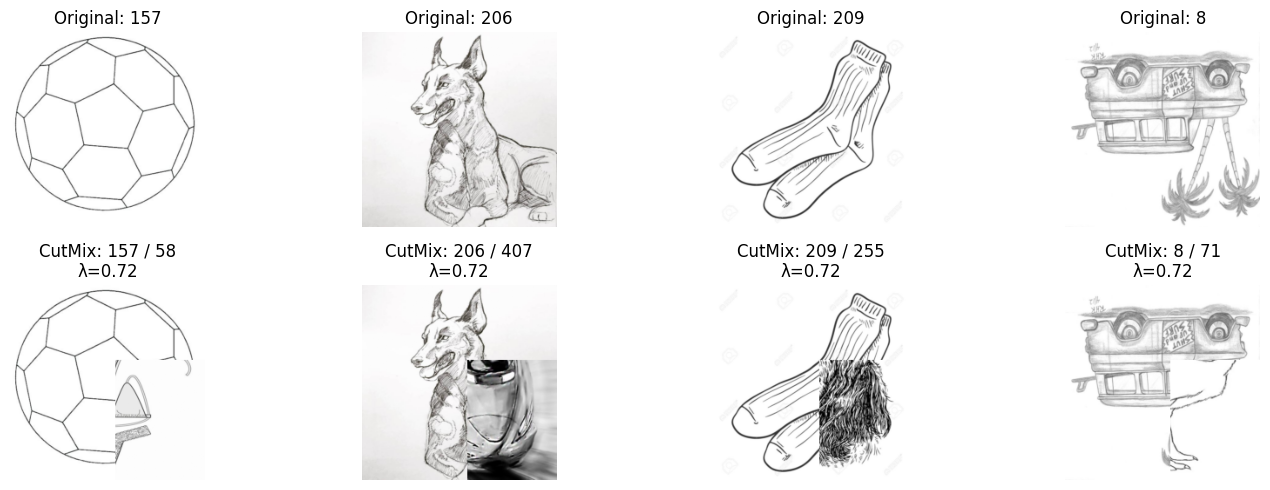

In [2]:

import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)  # np.int 대신 int 사용
    cut_h = int(H * cut_rat)  # np.int 대신 int 사용

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

def imshow(img):
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

class CustomDataset(Dataset):
    def __init__(self, root_dir, info_df, transform=None):
        """
        Args:
            root_dir (str): 데이터셋의 루트 디렉토리 경로
            info_df (pd.DataFrame): 이미지 파일 경로 및 레이블을 포함하는 데이터프레임
            transform (callable, optional): 이미지에 적용할 변환 함수
        """
        self.root_dir = root_dir
        self.info_df = info_df
        self.transform = transform

        # 레이블을 문자열에서 정수로 매핑
        self.label_mapping = {label: idx for idx, label in enumerate(self.info_df['target'].unique())}
        
        # 레이블을 정수로 변환
        self.info_df['target'] = self.info_df['target'].map(self.label_mapping)

    def __len__(self):
        return len(self.info_df)

    def __getitem__(self, idx):
        # 파일 경로 및 레이블 가져오기
        img_name = os.path.join(self.root_dir, self.info_df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.info_df.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def create_info_df(root_dir):
    """
    폴더 구조를 반영하여 이미지 파일 경로와 레이블을 포함하는 데이터프레임 생성
    Args:
        root_dir (str): 데이터셋의 루트 디렉토리 경로
    Returns:
        pd.DataFrame: 이미지 파일 경로 및 레이블을 포함하는 데이터프레임
    """
    img_paths = []
    labels = []
    for label_folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, label_folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_paths.append(os.path.join(label_folder, img_name))
                labels.append(label_folder)
    return pd.DataFrame({'img': img_paths, 'target': labels})

# 데이터 경로 및 정보 파일
train_data = '/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/data/train'
train_info = create_info_df(train_data)

train_df, val_df = train_test_split(
    train_info, 
    test_size=0.2,
    stratify=train_info['target']
)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

train_dataset = CustomDataset(root_dir=train_data, info_df=train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# CutMix 적용 및 시각화
images, labels = next(iter(train_loader))
cutmix_images, cutmix_targets = cutmix(images, labels, alpha=1.0)

def imshow(img):
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

plt.figure(figsize=(15, 5))

for i in range(4):  # 4개의 이미지만 시각화
    plt.subplot(2, 4, i+1)
    imshow(images[i])
    plt.title(f"Original: {labels[i].item()}")

    plt.subplot(2, 4, i+5)
    imshow(cutmix_images[i])
    target1, target2, lam = cutmix_targets
    plt.title(f"CutMix: {target1[i].item()} / {target2[i].item()}\nλ={lam:.2f}")

plt.tight_layout()
plt.show()
